# Package import

In [1]:
# for loading the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# for instantiating the model
import tensorflow as tf
if int(tf.__version__.split(".")[0]) == 2:
    tf.compat.v1.disable_eager_execution()
    from models.tfv2_model_auc_cons import AUCCons
    from models.tfv2_model_ptw_cons import PtwCons
    from models.tfv2_model_other_auc_cons import (AUCConsBNSP,
                                                  AUCConsBPSN,
                                                  AUCConsXAUC)
else:
    from models.model_auc_cons import AUCCons
    from models.model_ptw_cons import PtwCons
    from models.model_other_auc_cons import (AUCConsBNSP,
                                             AUCConsBPSN,
                                             AUCConsXAUC)

# to define a path where the results are saved
import pathlib

# to find out how long the fitting takes
import datetime

# for plotting the ROC curve in the end
import matplotlib.pyplot as plt

**Some general remarks:** I left out all kind of print statements about memory usage as I would like to keep the notebook as slim as possible.

# Loading the data

First, we need to define the function that loads the data. That should be load_compas_data() from load_data.py. I just took the relevant code from load_data.py as we don't want all the code for all datasets in here.

In [2]:
TEST_SIZE_COMPAS = 0.2

def load_compas_data():
    # See https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
    # Load the two-year data
    df = pd.read_csv('data/compas-scores-two-years.csv') # This path got adjusted so that we don't have too many subfolders

    # vr = violent recidivism
    # r = recidivism
    # Types of crimes in the USA: felonies and misdemeanors
    interesting_cols = [  # 'compas_screening_date',
        'sex',  # 'dob',
        'age', 'race',
        'juv_fel_count', 'decile_score', 'juv_misd_count',
        'juv_other_count', 'priors_count',
        'days_b_screening_arrest',
        'c_jail_in', 'c_jail_out',
        'c_charge_degree',
        'is_recid',
        'v_decile_score',
        'decile_score.1',
        ]
    df = df[interesting_cols]
    df = df[np.logical_and(df["days_b_screening_arrest"] >= -30,
                           df["days_b_screening_arrest"] <= 30)]
    df["days_in_jail"] = [a.days for a in (pd.to_datetime(df["c_jail_out"]) -
                                           pd.to_datetime(df["c_jail_in"]))]
    df = df[df["is_recid"] >= 0]
    df = df[df["c_charge_degree"] != "O"]
    # df = df[[x in {"Caucasian", "African-American"} for x in df["race"]]]
    Z = np.array([int(x == "African-American") for x in df["race"]])
    Y = 2*df["is_recid"].values - 1

    cols_to_delete = ["c_jail_out", "c_jail_in", "days_b_screening_arrest"]
    df = df[[a for a in df.columns if a not in cols_to_delete]]

    col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count",
                  "priors_count", "v_decile_score", "decile_score.1",
                  "days_in_jail"]
    col_quali = ["race", "c_charge_degree"]

    X_quali = df[col_quali].values
    X_quanti = df[col_quanti].values

    quali_encoder = OneHotEncoder(categories="auto")
    quali_encoder.fit(X_quali)

    X_quali = quali_encoder.transform(X_quali).toarray()

    X = np.concatenate([X_quanti, X_quali], axis=1)

    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
        X, Y, Z, test_size=TEST_SIZE_COMPAS, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)

# In the following function, I removed all the other datasets as we're just trying out the compas dataset here
def load_db_by_name(db_name):
    if db_name == "compas":
        return load_compas_data()
    raise ValueError("Wrong db name...")

I'm just testing shortly whether the above defined functions work. --> It looks like it does.

In [3]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("compas")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])


First few rows of X_train:
[[ 0.45923617 -0.1257918  -1.20229829 -0.18721999 -0.69278746 -1.05870501
  -1.20229829 -0.3137581  -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.82140605 -0.1257918  -0.14667911 -0.18721999 -0.4813843  -0.25612127
  -0.14667911 -0.29195745 -1.03820131 -0.07552357 -0.70818125 -0.30054426
  -0.04028706  4.0628921   0.73937757 -0.73937757]
 [ 0.11773158 -0.1257918   0.55706701 -0.18721999  1.63264728  0.14517061
   0.55706701 -0.27015679 -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]]

First few values of Z_train (sensitive attributes):
[0 0 0]

First few labels of y_train:
[-1  1  1]

First few rows of X_test:
[[-0.7360299  -0.1257918   1.96455926 -0.18721999  2.0554536   2.55292183
   1.96455926 -0.16115352  0.96320434 -0.07552357 -0.70818125 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.30914916 -0.1257918  -0.49855217  1.857702

# Defining a method to get an instance of the model

Next in the fit.py script of the paper's repo, there's load_model() function which is called from the utils.py file. According to utils.py, this function returns and instantiation of the model.

For example acc. to model_auc_cons.py, we don't necessary need to hand over param_files when calling the load_model function as there are some default values defines in the model classes. We could adjust the parameter.

In [4]:
# Taking the relevant code for intantiating the model

# define a dictionary, mapping of model type identifiers to their corresponding class definitions
MODEL_PATH_TO_CLASS = {"auc_cons": AUCCons,
                       "auc_cons_bnsp": AUCConsBNSP,
                       "auc_cons_bpsn": AUCConsBPSN,
                       "auc_cons_xauc": AUCConsXAUC,
                       "ptw_cons": PtwCons}

def load_model(model_name, param_files=None):
    """Returns an instantiation of the model."""
    return MODEL_PATH_TO_CLASS[model_name](param_files=param_files)

# Instantiating a BPSN model

A BPSN model is a model with an AUC-based fairness constraint. Let's try to load one.

In [5]:
bpsn_model = load_model("auc_cons_bpsn")

Parameters:
n_iter : 50000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0


Next, we hardcode a folder where the results are saved

In [6]:
# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

# Fitting the data to the BPSN model

In [7]:
time_2 = datetime.datetime.now()
bpsn_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

Number of features: 16
Size of the train set: 4443
Size of the validation set: 494
Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.70200 | +0.68500 | +0.50000 | +0.01700 | +0.00000 | +0.03974 | +0.00000
te | +0.50004 | +0.69015 | +0.63785 | +0.50000 | +0.05230 | +0.00000 | +0.03974 | +0.00000
Iter   0   ---------- 8/5/24 - 19:13:2 -----


2024-05-08 19:13:02.002195: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.61600 | +0.61500 | +0.50000 | +0.00100 | +0.00000 | +0.03924 | +0.01000
te | +0.50004 | +0.55905 | +0.58260 | +0.50000 | -0.02355 | +0.00000 | +0.03924 | +0.01000
Iter  500  ---------- 8/5/24 - 19:13:2 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.35700 | +0.49300 | +0.50000 | -0.13600 | +0.00000 | +0.03884 | +0.00000
te | +0.50004 | +0.33140 | +0.48430 | +0.50000 | -0.15290 | -0.00000 | +0.03884 | +0.00000
Iter 1000  ---------- 8/5/24 - 19:13:3 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.22200 | +0.35400 | +0.50000 | -0.13200 | -0.00000 | +0.03854 | -0.01000
te | +0.50004 | +0.26580 | +0.41300 | +0.50000 | -0.14720 | -0.00000 | +0.03854 | -0.01000
Iter 1500  ---------- 8/5/24 - 19:13:3 -----
dt |  r_cost  |   cost   |   auc    |  r_auc  

After fitting the model, we can simply output some information and save the model to the defined folder.

In [8]:
# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("compas"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
bpsn_model.save_model(exp_path)

# Evaluation

In [9]:
s_test = np.array(bpsn_model.score(X_test)).ravel().astype(float)
s_train = np.array(bpsn_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

The following code is taken from ./more_utils/roc_calculus.py

In [10]:
def fpr_tpr(scores, classes):
    """
        Computes the ROC curves from scores and classes of comparisons.
        Does not work if the distributions of the scores are not continuous.
    """
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    ind_sort = np.argsort(scores)  # argsort, increasing order
    cl_sort = classes[ind_sort]

    fnr_ar = cl_sort.cumsum()/n_pos
    tnr_ar = (1-cl_sort).cumsum()/n_neg
    fpr_ar = 1 - tnr_ar

    return fpr_ar, 1 - fnr_ar

The following code is taken from ./more_utils/roc_plot.py and adjusted by leaving out unnecessary parts.

In [11]:
LEGEND_SIZE = (10.5, 1)


class RocGen:
    def __init__(self, s_1, s_2, out_fold):
        self.s_1 = s_1
        self.s_2 = s_2
        self.out_fold = out_fold
        self.prefix = ""

    def save_roc(self, fpr, tpr):
        fold = pathlib.Path("{}/{}".format(self.out_fold, "rocs"))
        if not fold.exists():
            fold.mkdir()
        path = fold/("{}".format(self.prefix))
        with open(str(path) + "fpr.npy", "wb") as f:
            np.save(f, fpr)
        with open(str(path) + "tpr.npy", "wb") as f:
            np.save(f, tpr)


class RocGenSec3(RocGen):
    def f_1(self, y, z):
        return z == 0

    def f_2(self, y, z):
        return z == 1

    def y_1(self, y, z):
        return y[self.f_1(y, z)]

    def y_2(self, y, z):
        return y[self.f_2(y, z)]


class RocGenSec4(RocGen):
    def f_1(self, y, z):
        return y != 1

    def f_2(self, y, z):
        return y == 1

    def y_1(self, y, z):
        return z[self.f_1(y, z)]

    def y_2(self, y, z):
        return z[self.f_2(y, z)]


def plot_roc(s, y, z, rocgen, ls="-"):
    fpr, tpr = fpr_tpr(s, y)

    fpr_1, tpr_1 = fpr_tpr(s[rocgen.f_1(y, z)], rocgen.y_1(y, z))
    fpr_2, tpr_2 = fpr_tpr(s[rocgen.f_2(y, z)], rocgen.y_2(y, z))
    fpr, tpr = fpr_tpr(s, y)

    plt.plot(fpr_1, tpr_1, label=rocgen.s_1, color="green", linestyle=ls)
    plt.plot(fpr_2, tpr_2, label=rocgen.s_2, color="blue", linestyle=ls)
    plt.plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle=ls)

    orig_prefix = rocgen.prefix
    rocgen.prefix = orig_prefix + "-1-"
    rocgen.save_roc(fpr_1, tpr_1)
    rocgen.prefix = orig_prefix + "-2-"
    rocgen.save_roc(fpr_2, tpr_2)
    rocgen.prefix = orig_prefix + "-main-"
    rocgen.save_roc(fpr, tpr)


def legend_get_handles(ls="-"):
    handles = list()
    for color in ["green", "blue", "black"]:
        handles.append(plt.Line2D([0], [0], color=color, linestyle=ls))
    return handles


def plot_roc_sec3(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(7, 7))

    s_1 = "$ROC_{H_s^{(0)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(1)}, G_s^{(1)}}$"
    rocgen = RocGenSec3(s_1, s_2, path_analysis)
    rocgen.prefix = "sec3-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec3-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec3.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left")
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right") # added the leg = here in the beginning
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec3.pdf")


def plot_roc_sec4(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(7, 7))

    plt.plot([0, 1], [0, 1], color="grey")
    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"
    rocgen = RocGenSec4(s_1, s_2, path_analysis)
    rocgen.prefix = "sec4-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec4-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec4.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left") # added the leg = here in the beginning
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right")
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec4.pdf")

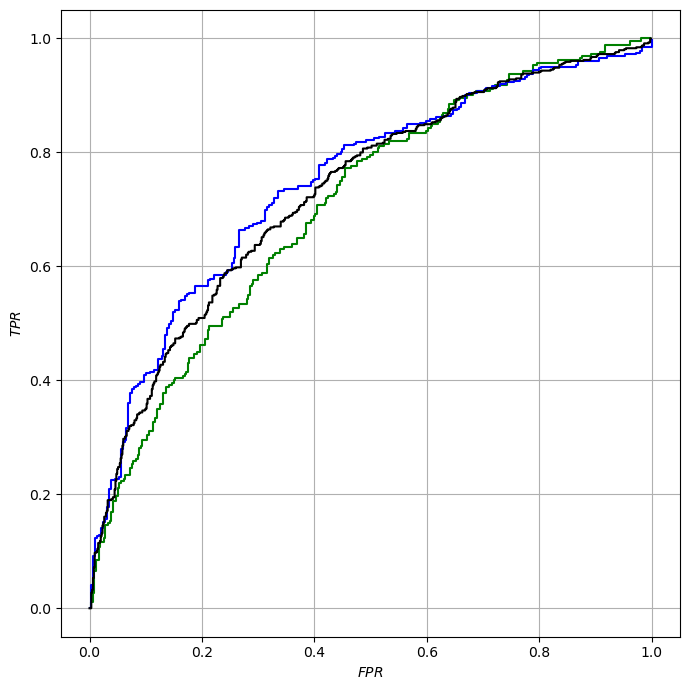

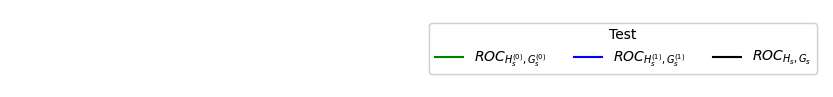

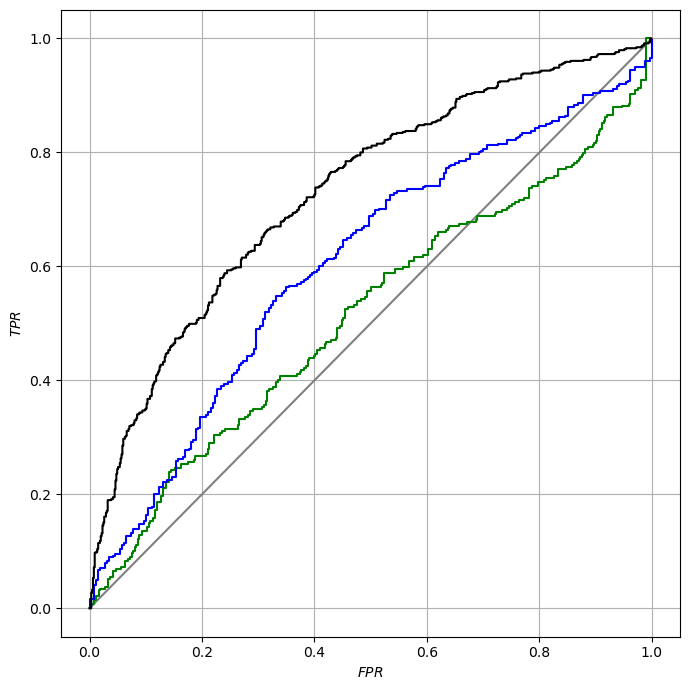

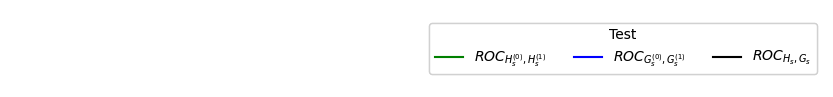

In [12]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))